In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
plt.style.use(['science', 'notebook'])
from openpyxl import load_workbook
import imageio
from scipy.interpolate import interp1d, interp2d

Load spreadsheets

In [14]:
def get_data_datasheet(file, sheet, skiprows, usecols, nrows, add_init=None):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy().ravel()
    idx = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    return np.append(add_init[0], idx), np.append(add_init[1], arr), 

def get_interp_datasheet_1D(file, sheet, skiprows, usecols, nrows, add_init=None):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy().ravel()
    idx = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    if add_init:
        idx = np.insert(idx,0,add_init[0])
        arr = np.insert(arr,0,add_init[1])
    #return interp1d(idx, arr, kind='linear', bounds_error=False, fill_value=(arr.ravel()[0], arr.ravel()[-1]))
    return interp1d(idx, arr, kind='linear', bounds_error=False, fill_value='extrapolate')

def get_interp_datasheet_2D(file, sheet, skiprows, usecols, nrows):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy()
    idx1 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[2], nrows=nrows[2], usecols=usecols[2]).to_numpy().ravel()
    idx2 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    return interp2d(idx1, idx2, arr)


Get interpolation functions

In [15]:
# Arguments: rd, d
TMR_int = get_interp_datasheet_2D('DATA1.xlsm', '6 MV TMR', skiprows=[3,3,2],
                                     usecols=['B:K', 'A', 'B:K'], nrows=[40,40,1])
# Arguments: rd
Sp_int = get_interp_datasheet_1D('DATA1.xlsm', 'Linac outputs', skiprows=[28, 27],
                                     usecols=['C:L', 'C:L'], nrows=[1,1],
                                     add_init=[0,1/1.078])

# Question 1

Read in data

In [64]:
d_sup = np.arange(0, 3.5, 0.5)
P_sup = np.array([19.1, 66.8, 85.7, 94.6, 98.8, 99.9, 100])
P_interp = get_interp_datasheet_1D('DATA1.xlsm', '18 MV PDD', skiprows=[3,3],
                          usecols=['F', 'A'], nrows=[40,40],
                         add_init = [d_sup, P_sup])

## Part A

Note that in this problem

* Equal weighting: $D_{Q} = \sum_i D_{Q_i} = D_{Q_1} + D_{Q_2}$
* Equal ${}_{S}D_{N}$ gives $D_{Q_i} = {}_{S}D_{(Q/N)_i} \cdot {}_{S}D_{N_i} = \frac{1}{2} {}_{S}D_{N} \cdot {}_{S}D_{(Q/N)_i}$

So we can plot the dose profile given by

$$\frac{D_{Q}}{{}_{S}D_{N}} = \frac{1}{2}\left({}_{S}D_{(Q/N)_1} + {}_{S}D_{(Q/N)_2} \right)$$

Furthermore, since we are not entering off axis or at an oblique angle, and the $SSD$ is standard, we can express this as 

$$\frac{D_{Q}}{{}_{S}D_{N}} = \frac{1}{2}\left(P(d, 15, 100) + P(22-d, 15, 100) \right)$$

Due to the symmetry of the problem, we need only evaluate this for the first 11cm; the result is mirrored.


In [65]:
d = np.linspace(0, 11, 1000)
dose_profile_f = lambda d: 1/2 * (P_interp(d) + P_interp(22-d))
dose_profile = dose_profile_f(d)
# Mirror over central axis
d= np.append(d, 22-np.flip(d))
dose_profile = np.append(dose_profile, np.flip(dose_profile))

Plot

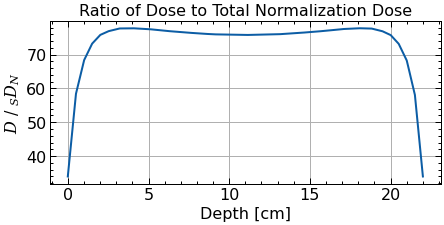

In [66]:
plt.figure(figsize=(7,3))
plt.plot(d, dose_profile)
plt.title('Ratio of Dose to Total Normalization Dose')
plt.xlabel('Depth [cm]')
plt.ylabel('$D~/~{}_{S}D_{N}$')
plt.grid()
plt.show()

## Part B

We scale the data above so that it corresponds to 2.2Gy at 11cm

In [67]:
dose = dose_profile * 2.2 / dose_profile_f(11)

And then find the maximum

In [68]:
print(f'The maximum dose along the central beam axis is {max(dose):.4f}Gy')

The maximum dose along the central beam axis is 2.2580Gy


## Part C

We extract the value at the surface

In [69]:
print(f'The skin dose on the central beam axis is {dose[0]:.4f}Gy')

The skin dose on the central beam axis is 0.9854Gy


# Question 2

## Part A

Isocentric setups are generally preferred for multiple beam therapy, since the isocenter can be established for all beam directions and the patient does not need to be moved throughout the treatment procedure.

## Part B

* An SSD setup would be preferred if the positioning of an applicator on a patient's body isn't possible due to anatomical limitations. In this case, extended SSD would need to be used.

* For single field treatments, SSD can be used, since there is no benefit to using an SAD formalism (in this case, it doesn't matter).

## Part C

In [70]:
theta = np.arctan(11/16)
d = np.sqrt((11**2+16**2) /4)
x = 16 - d*np.cos(theta)
y = d*np.sin(theta)

Thus, assuming a standard reference frame of $\hat{x}$ pointing towards "LEFT" and $\hat{y}$ pointing up the page, 

In [75]:
print(f'The patient should be moved ({-x}, {-y}) cm')


The patient should be moved (-8.0, -5.5) cm


## Part D

The SSD is given by  $SAD - d$  where $SAD=100$cm and $d$ is the distance from the left setup mark to the treatment isocenter.

In [76]:
SSD = 100 - d
print(f'The source to surface distance is {100-d:.2f}cm')

The source to surface distance is 90.29cm


## Part E

The right lateral setup mark can be used with the left lateral setup mark  to ensure the patient is lying flat before treatment begins.

# Question 3